# Hyper-parameter search for ODE-ELM

In [1]:
import sys
sys.path.append('../../../')
sys.path.append('../../../src')
from swimpde import Domain
from swimpde import BasicAnsatz
from swimpde import BurgersSolver
import numpy as np
from sklearn.metrics import mean_squared_error
import scipy.io
import time
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'jet'

### Load data and reference solution

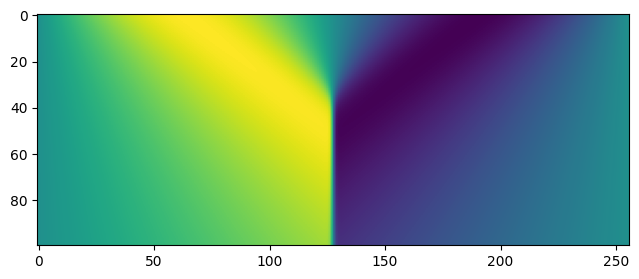

In [2]:
# Load and visualize data
data = scipy.io.loadmat('../../../data/burgers_shock.mat')
t_eval = data['t'].flatten()[:,None]
x_eval = data['x'].flatten()[:,None]
u_exact = np.real(data['usol']).T
X, T = np.meshgrid(x_eval,t_eval)
X_ = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Set ground truth
u_true = u_exact.flatten()[:,None]              

### Problem setup

In [3]:
# initial condition
def u0(x):
    return -1 * np.sin(np.pi * x)

# forcing
def forcing(x, t):
    return np.zeros(x.shape[0])

# boundary condition
boundary_condition = "zero dirichlet" # 

# Domain information and spacial points for the first time-block
n_points_1d = 4000 #320 # 258 #square root of number of points
x_lim = [-1, 1]
rng = np.random.default_rng(seed=123)
x_space = rng.uniform(x_lim[0], x_lim[1], n_points_1d).reshape((-1, 1))
x_space_inner = x_space[1:-1]
interior_points = x_space_inner

# coordinates of boundary points (excluding corners)
left = x_lim[0]
right = x_lim[1]
boundary_points = np.row_stack([left, right])

### Train and evaluate ODE-ELM for different hyper-parameters

In [ ]:
# Probability distribution 
n_sample = [5000]
n_col = [8000, 5000, 2000, 1000, 500]
ratios = [10, 4, 3, 2, 1.5]
grad_percent = [0.01]
reg_consts = [1e-6, 1e-8, 1e-10, 1e-12]
svd_cutoffs = [1e-8, 1e-10, 1e-12, 1e-14]
domain_margin_percent = [1, 10]
seeds = [1, 2, 3]
range_m = [10, 5, 4, 3, 1]
time_blocks = 3
experiments = []
for d_m in domain_margin_percent:
    for n_s in n_sample: # Number of training data points
        for n_c in n_col:
            for r in ratios: 
                for g_p in grad_percent:
                    for r_c in reg_consts:
                        for r_m in range_m: # Only for ELM 
                            for svd_co in svd_cutoffs:
                                info = []
                                info.append(d_m) # Domain margin percent
                                info.append(n_s) # No. of sampling points (for computing gradients)
                                info.append(n_c) # No. of collocation points (re-sampled)
                                width = int(n_c/r)
                                info.append(width) # Width
                                info.append(g_p) # Percent of gradient added to the prob distribution for sampling collocation points
                                info.append(r_c) # Regularization const
                                info.append(r_m) # Range for uniform sampling of biases in ELM
                                info.append(svd_co) # Scaling factor for boundary conditions
                                
                                # Compute prob. distribution for (re)-sampling collocation points
                                def collocation_points_probabilities(df_dx):
                                    gradients = np.abs(df_dx)
                                    gradients = gradients + g_p * np.max(gradients)
                                    return gradients/np.sum(gradients)

                                sample_test_points = np.sort(rng.uniform(x_lim[0] + 1e-4, x_lim[1] - 1e-4, n_s)).reshape((-1, 1)) # This does not include boundary points
                                domain = Domain(
                                    interior_points=interior_points,
                                    boundary_points=boundary_points,
                                    sample_points = sample_test_points
                                )
                                
                                # Loop over different seeds
                                rel_err_elm = np.ones((len(seeds), ))
                                time_elm = np.ones((len(seeds), ))
                                rmse_elm = np.ones((len(seeds), ))
                                j = 0
                                def parameter_sampler_uniform(x, y, rng):
                                    """
                                        returns: weights, biases, idx_from, idx_to
                                    """
                                    n_dim = 1
                                    x_left = -r_m
                                    x_right = r_m
                                    weights = rng.uniform(x_left, x_right, size=(n_dim, width)) #rng.normal(size=(n_dim, width)) ## 
                                    biases = rng.uniform(x_left, x_right, size=(1, width))
                                    idx_from = np.arange(width)
                                    idx_to = np.arange(width)
                                    return weights, biases, idx_from, idx_to

                                
                                # Loop over different seeds
                                for seed in seeds: # Run for 3 seeds                                    
                                    ansatz_elm = BasicAnsatz(
                                        n_neurons=width,
                                        activation="tanh",
                                        random_state=seed,
                                        regularization_scale=r_c,
                                        parameter_sampler = parameter_sampler_uniform,
                                        #parameter_sampler="random"
                                    )
                                    burgers_solver_elm = BurgersSolver(
                                        domain=domain, 
                                        ansatz=ansatz_elm,
                                        u0=u0,
                                        boundary_condition=boundary_condition,
                                        forcing=forcing,
                                        regularization_scale=r_c,
                                        c=(0.01/np.pi),
                                    )
                                   
                                    # ELM fit
                                    t_elm_start = time.time()
                                    sol_elm, solver_status_elm = burgers_solver_elm.fit_time_blocks(t_span=[0, np.max(t_eval)], rtol=1e-8, atol=1e-8, svd_cutoff=svd_co, time_blocks=time_blocks, prob_distr_resampling = collocation_points_probabilities, n_col=n_c, outer_basis=False);
                                    t_elm_stop = time.time()
                                    time_elm[j] = t_elm_stop - t_elm_start

                                    # Evaluate on ELM and SWIM
                                    pred_elm = burgers_solver_elm.evaluate_blocks(x_eval= x_eval, t_eval = t_eval, time_blocks = time_blocks, solver_status = solver_status_elm)

                                    # True and model solutions
                                    u_elm = pred_elm.T

                                    mse_elm = mean_squared_error(u_true, u_elm.flatten()[:,None])  # mean squared error
                                    rmse_elm[j] = np.sqrt(mse_elm)  # Root Mean Squared Error
                                    rel_err_elm[j] = np.linalg.norm(u_true-u_elm.flatten()[:,None], 2)/np.linalg.norm(u_true,2)
                                    print("rmse_elm, re_elm")
                                    print(rmse_elm[j], rel_err_elm[j])
                                    j += 1
                                
                                info.append(np.mean(time_elm))
                                info.append(np.mean(rmse_elm))
                                info.append(np.mean(rel_err_elm))

                                print("d_m, n_s, n_c, width, g_p, r_c, r_m, svd_cutoff, time_elm, rmse_elm, re_elm")
                                print(info)
                                experiments.append(info)

